In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from IPython.display import HTML
from IPython.display import display

%matplotlib inline


/anaconda/envs/tensor34/lib/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Utility Function

In [2]:
def generate_html_for_table(matrix):
    tablestr = "<table>"
    # first row is header
    for i in range(len(matrix)):
        tablestr = tablestr + "<tr>"
        for j in range(len(matrix[i])):
            if( i ==0):
                tablestr += "<th>" + matrix[i][j] + "</th>"
            else:
                tablestr += "<td>" + matrix[i][j] + "</td>"
        tablestr = tablestr + "</tr>"
    tablestr = tablestr + "</table>"
    return tablestr

In [3]:
def read_images_from_files(image_files):
    images = []
    for image_file in image_files:
        images.append(cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB))
    return images

#### Loading Traning data vehicle and non-vehicle and its exploration

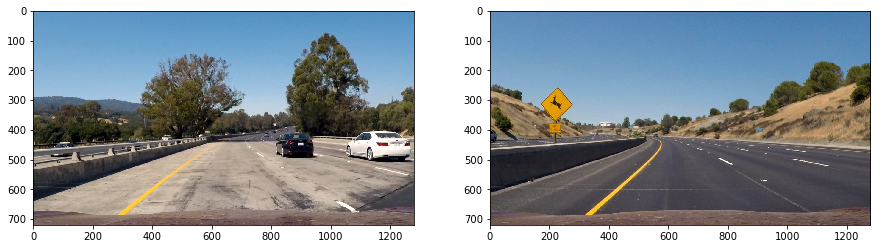

In [4]:
car_img_test = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
notcar_img_test = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
fig, (car, no_car) = plt.subplots(1, 2, figsize=(15,15))
car.imshow(car_img_test)
no_car.imshow(notcar_img_test)

In [5]:
vehicle_files = glob.glob('vehicles/**/*.png')
non_vehicles_files = glob.glob('non-vehicles/**/*.png')
print ("Count of vehicle images %d = " %len(vehicle_files))
print ("Count of non-vehicle images = %d" %len(non_vehicles_files))

Count of vehicle images 8792 = 
Count of non-vehicle images = 8968


In [6]:
vehicle_imgs = read_images_from_files(vehicle_files)
non_vehicle_imgs = read_images_from_files(non_vehicles_files)

#### Samples images of vehicle and non-vehicle in our training data

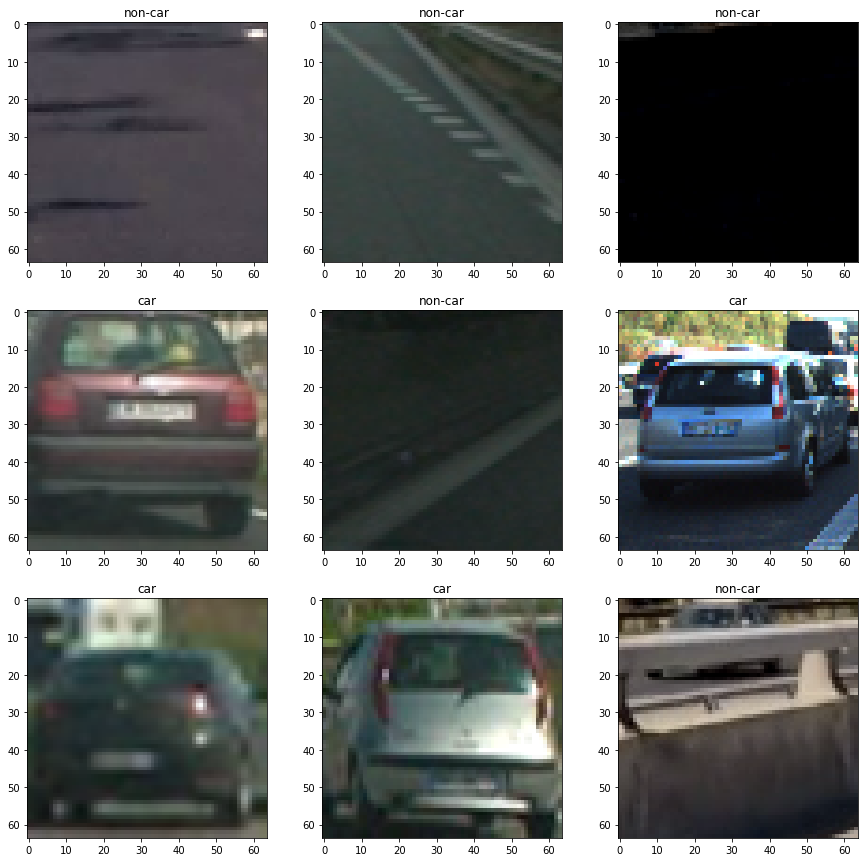

In [7]:
samp_car_imgs = []
samp_non_car_imgs = []
fig, axis = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        random_num = np.random.choice(2)
        if (random_num == 0):
            #car image
            k = np.random.choice(len(vehicle_imgs))
            axis[i, j].imshow(vehicle_imgs[k])
            axis[i, j].set_title("car")
            samp_car_imgs.append(vehicle_imgs[k])
        else:
            k = np.random.choice(len(non_vehicle_imgs))
            axis[i, j].imshow(non_vehicle_imgs[k])
            axis[i, j].set_title("non-car")
            samp_non_car_imgs.append(non_vehicle_imgs[k])


In [8]:
samp_car_imgs = np.array(samp_car_imgs)
samp_non_car_imgs = np.array(samp_non_car_imgs)

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

### 1.a Histogram of Oriented Gradients (HOG)

In [9]:
class Vehicle_feature_parameter:
    def __init__(self):
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        
        self.cspace = ['HSV', 'HLS', 'YUV', 'LUV', 'RGB','YCrCb']

In [10]:
feature_params = Vehicle_feature_parameter()

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [12]:
def get_hog_image(img, cspace, channel, hgp):
    timage = img
    if cspace != 'GRAY':
        timage = img
        if cspace == 'HSV':
            timage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            timage = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            timage = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            timage = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            ## unhandled exception.
            timg = img
        
        timage = timage[:,:,channel]
        
    if cspace == 'GRAY':
        timage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    _, hog_image = get_hog_features(timage, hgp.orient, hgp.pix_per_cell, hgp.cell_per_block, vis=True)
    return hog_image

In [13]:
def get_all_hog_imgs_comb(img, fp, main_title="Car"):
    output = []
    titles = []
    output.append(img)
    titles.append(main_title)
    for color in fp.cspace:
        for channel in range(3):
            title = main_title + "_" + color +"_channel_" + str(channel)
            hog_img = get_hog_image(img, color, channel, fp)
            output.append(hog_img)
            titles.append(title)
    return output, titles

In [14]:
car_img = samp_car_imgs[0]
notcar_img = samp_non_car_imgs[0]

### 1.b visualtion of sample orignial, gray image and Hog image.

#### From figure, it seems to be hog features keeps the shape of object.

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


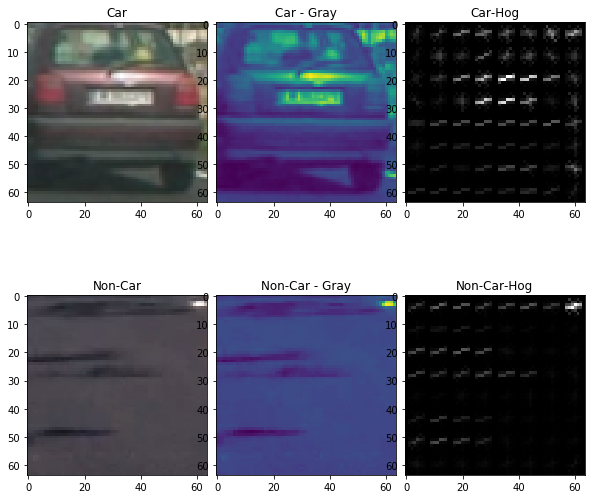

In [15]:
fig, axis = plt.subplots(2,3, figsize=(10,10))
fig.subplots_adjust(hspace = .005, wspace=0.05)
axis[0,0].imshow(car_img)
axis[0,0].set_title("Car")
axis[0,1].imshow(cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY))
axis[0,1].set_title("Car - Gray")
axis[0,2].imshow(get_hog_image(car_img, 'GRAY', -1, feature_params), 'gray')
axis[0,2].set_title("Car-Hog")

axis[1,0].imshow(notcar_img)
axis[1,0].set_title("Non-Car")
axis[1,1].imshow(cv2.cvtColor(notcar_img, cv2.COLOR_RGB2GRAY))
axis[1,1].set_title("Non-Car - Gray")
axis[1,2].imshow(get_hog_image(notcar_img, 'GRAY', -1, feature_params), 'gray')
axis[1,2].set_title("Non-Car-Hog")

### 1.c Exploration of different color space and channel for Hog features extraction.

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


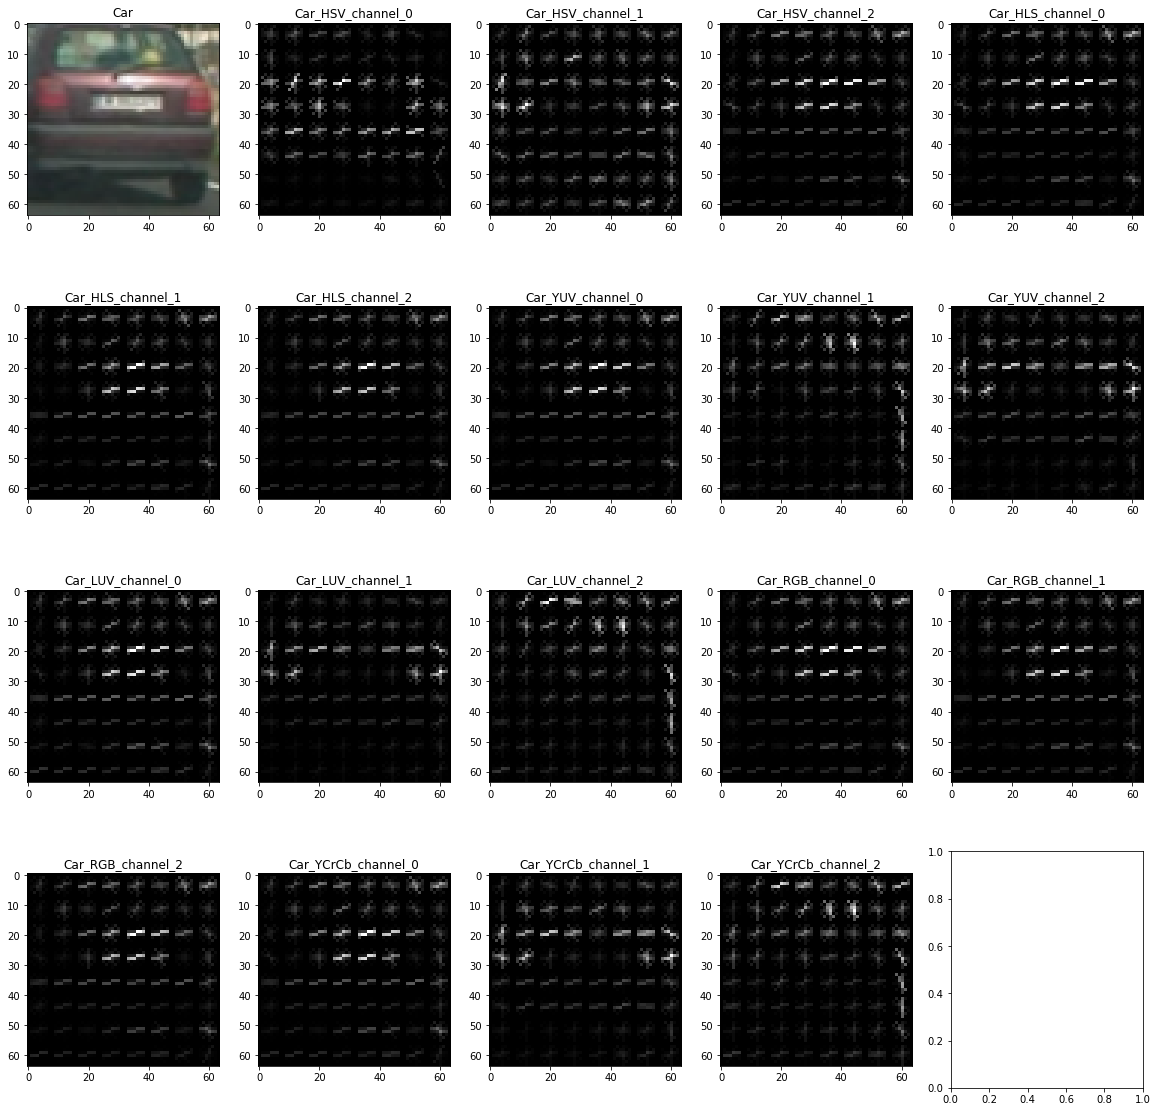

In [16]:
get_all_hog_imgs_comb(car_img, feature_params)
hog_imgs, titles = get_all_hog_imgs_comb(car_img, feature_params)
fig, axis = plt.subplots(4,5, figsize=(20,20))
k = 0
for i in range(4):
    for j in range(5):
        if (k >= len(titles)):
            continue
        axis[i,j].imshow(hog_imgs[k], 'gray')
        axis[i,j].set_title(titles[k])
        k += 1

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


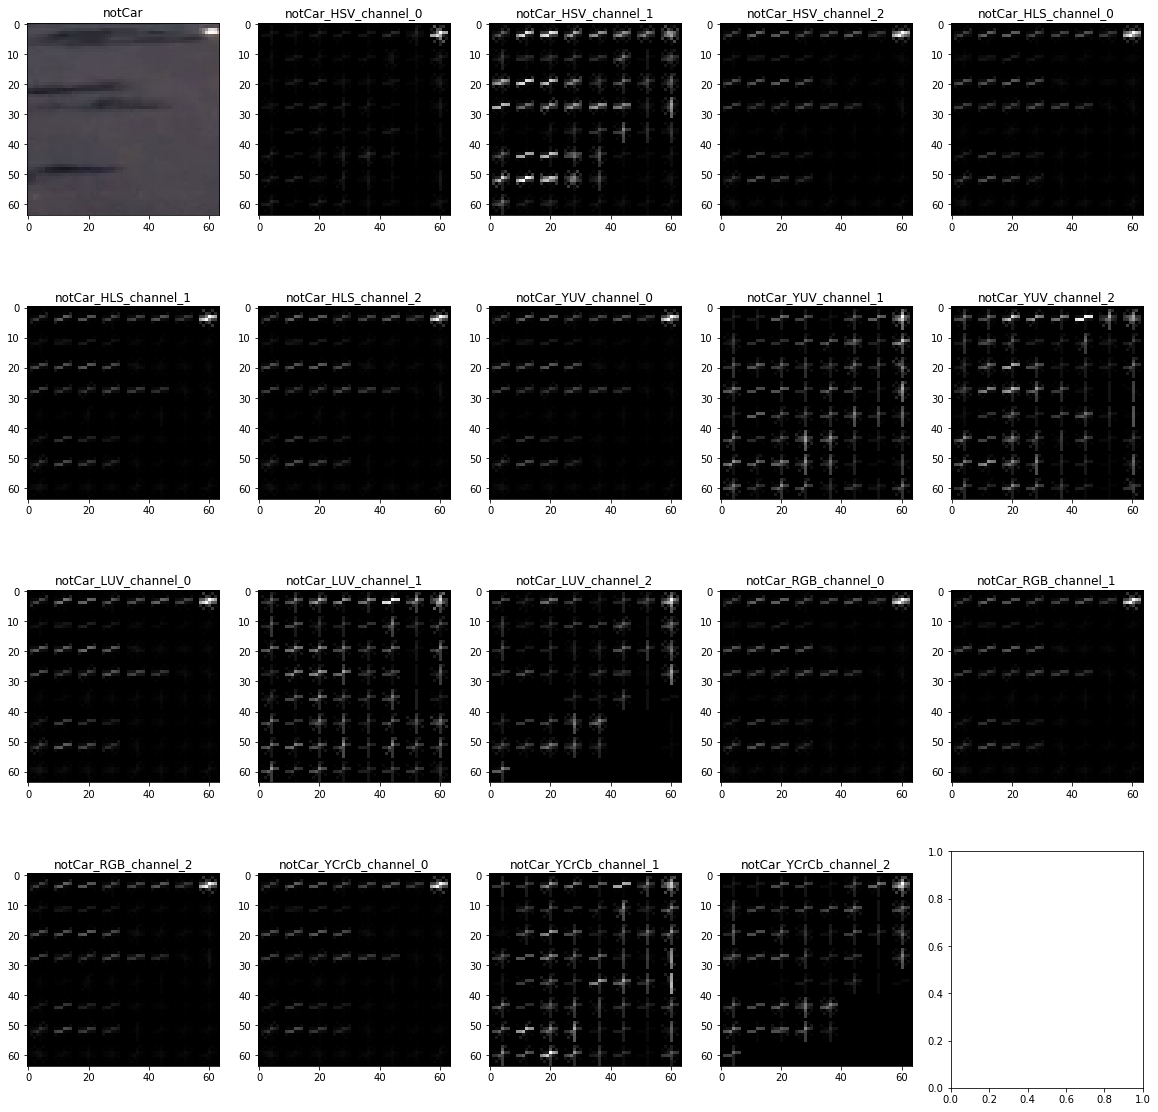

In [17]:
hog_imgs, titles = get_all_hog_imgs_comb(notcar_img, feature_params, "notCar")
fig, axis = plt.subplots(4,5, figsize=(20,20))
k = 0
for i in range(4):
    for j in range(5):
        if (k >= len(titles)):
            continue
        axis[i,j].imshow(hog_imgs[k], 'gray')
        axis[i,j].set_title(titles[k])
        k += 1

### 1.d Parameter selections using visualtion of different color space images

One way to do parameter selection is - apply all possible parameter combination, and choose the classifier which fits best with training data. But, cost of selection of classifier is costly operations. It is also visible from above figure, few of the color space is not useful, hence can be easily discarded.
From above image analysis and experience from previous assignment, below parameters are considered. Out of these below parameters, Calssifier with best parameter is choosen.

In [18]:
feature_params.cspace_channel_search = [('HLS', 1), ('HLS', 2), ('YCrCb', 0), ('YCrCb', 1), ('YCrCb', 2),
                                 ('LUV', 1)]
feature_params.orient_search = [8, 9, 10, 11, 12]
feature_params.cell_per_block_search = [2, 4]

### 1.e Normalization function
It normalizes and return the best normalization fits with training data, which will be used to normalize test data.

In [19]:
def Normalize_Return_NormalizationScalarObj(car_features, notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    return X_scaler, scaled_X
    

### 1.f Feature extraction.

This code is partially taken from study materials.

In [36]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [37]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    for img in imgs:
        features.append(single_img_features(img, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins,
                                            cell_per_block=cell_per_block, hog_channel=hog_channel))
    return features

In [38]:
car_features = extract_features(vehicle_imgs)
non_car_features = extract_features(non_vehicle_imgs)
print("Input images")

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Input images


In [39]:
print("Input Car Image = " + str(np.array(vehicle_imgs).shape))
print("Feature Car Image = " + str(np.array(car_features).shape))
print("Input NonCar Image = " + str(np.array(non_vehicle_imgs).shape))
print("Feature Noncar Image = " + str(np.array(non_car_features).shape))

Input Car Image = (8792, 64, 64, 3)
Feature Car Image = (8792, 1764)
Input NonCar Image = (8968, 64, 64, 3)
Feature Noncar Image = (8968, 1764)


### 1.g - Training SVM classifier
It involves - 
    a. Normalizing the data.
    b. Splitting training and test data.
    c. training the model on train data and measuring the accuracy of model using test data

In [42]:
def Train_SVM_Classifier(car_features, notcar_features, debug_flag=False):
    # Normalize the training data.
    normalizer , scaled_X = Normalize_Return_NormalizationScalarObj(car_features, notcar_features)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    train_time = round(t2-t, 2)
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    
    if debug_flag:
        print(train_time, 'Seconds to train SVC...')
        print('Test Accuracy of SVC = ', accuracy)
        # Check the prediction time for a single sample
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
        print("Feature dimension = ", str(len(X_train[0])))
        print (svc)
    return svc, normalizer, accuracy, train_time

### 1.h SVM classifier training on car and non-car images.

In [43]:
 _,_,_,_ = Train_SVM_Classifier(car_features, non_car_features, debug_flag=True)

7.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9412
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
7.27869 Seconds to predict 10 labels with SVC
Feature dimension =  1764
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


### 2. Explain how you settled on your final choice of HOG parameters.

Hog parameters are choosing by classifier which has hightest accuracy. In order to decrease search space, color, channel and other parameters are selected using visualization and experience. This decreased search space from million to 100 parameters. Then parameter is choosing by bruter force strategy.

Below is the code to select the parameters - Classifier having highest accuracy

In [51]:
final_classifier_params = Vehicle_feature_parameter()
final_classifier = None
cur_accuracy = 0.0
parameters = [["Color", "Channel", "Orientation", "Pixel per Cell", "Cell per Block", "Accuracy", "Time"]]
for (color_s, channel_s) in feature_params.cspace_channel_search:
    for orient_s in feature_params.orient_search:
        for cell_per_block_s in feature_params.cell_per_block_search:
            car_features = extract_features(vehicle_imgs, color_space=color_s, hog_channel=channel_s,orient=orient_s,
                                           cell_per_block=cell_per_block_s)
            notcar_features = extract_features(non_vehicle_imgs, color_space=color_s, hog_channel=channel_s,orient=orient_s,
                                           cell_per_block=cell_per_block_s)
            clf, normlizer, acc, ttime = Train_SVM_Classifier(car_features, notcar_features)
            temp = [str(color_s), str(channel_s), str(orient_s), str(feature_params.pix_per_cell), str(cell_per_block_s),
                   str(acc), str(ttime)]
            parameters.append(temp)
            if cur_accuracy < acc:
                final_classifier_params.color_space = color_s
                final_classifier_params.channel = channel_s
                final_classifier_params.pix_per_cell = feature_params.pix_per_cell
                final_classifier_params.cell_per_block = cell_per_block_s
                final_classifier_params.orient = orient_s
                final_classifier_params.clf_acc = acc
                final_classifier = clf
                final_classifier_params.fd= len(car_features[0])
                final_classifier_params.normalizer = normlizer
                cur_accuracy = acc
            print ("Accuracy " + str(acc))
            break
        break
    break
    

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Accuracy 0.949


In [52]:
display(HTML(generate_html_for_table(parameters)))

Color,Channel,Orientation,Pixel per Cell,Cell per Block,Accuracy,Time
HLS,1,8,8,2,0.949,6.45


In [ ]:
Train_SVM_Classifier(car_features, non_car_features, )

#### Hog feature parameters and acccuracy of model

### 1.k Best parameters choosen for Feature extraction and model

In [53]:
print ("Orientation = " + str(final_classifier_params.orient))
print ("Color = " + str(final_classifier_params.color_space))
print ("Channel = " + str(final_classifier_params.channel))
print ("Pixels per cell = " + str(final_classifier_params.pix_per_cell))
print ("Cell per block = " + str(final_classifier_params.cell_per_block))
print ("Accuracy of model = " + str(final_classifier_params.clf_acc))
print ("SVM model = " + str(final_classifier))
print ("Feature dimension = " + str(final_classifier_params.fd))

Orientation = 8
Color = HLS
Channel = 1
Pixels per cell = 8
Cell per block = 2
Accuracy of model = 0.949
SVM model = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Feature dimension = 1764


### 1.k predicting the score and label for given image

In [71]:
def predict_score(img, clf, fp):
    feature = extract_features([img], color_space=fp.color_space, hog_channel=fp.channel,orient=fp.orient,
                                           cell_per_block=fp.cell_per_block)
    feature = fp.normalizer.transform(feature)
    predict_scores = clf.predict(feature)
    predict_score = predict_scores[0]
    if predict_score < 0.01:
        predict_label = "NOT-CAR"
    else:
        predict_label = "CAR"
    return predict_score, predict_label

### 1.i  - Testing prediction on random car/notcar images

/anaconda/envs/tensor34/lib/python3.4/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


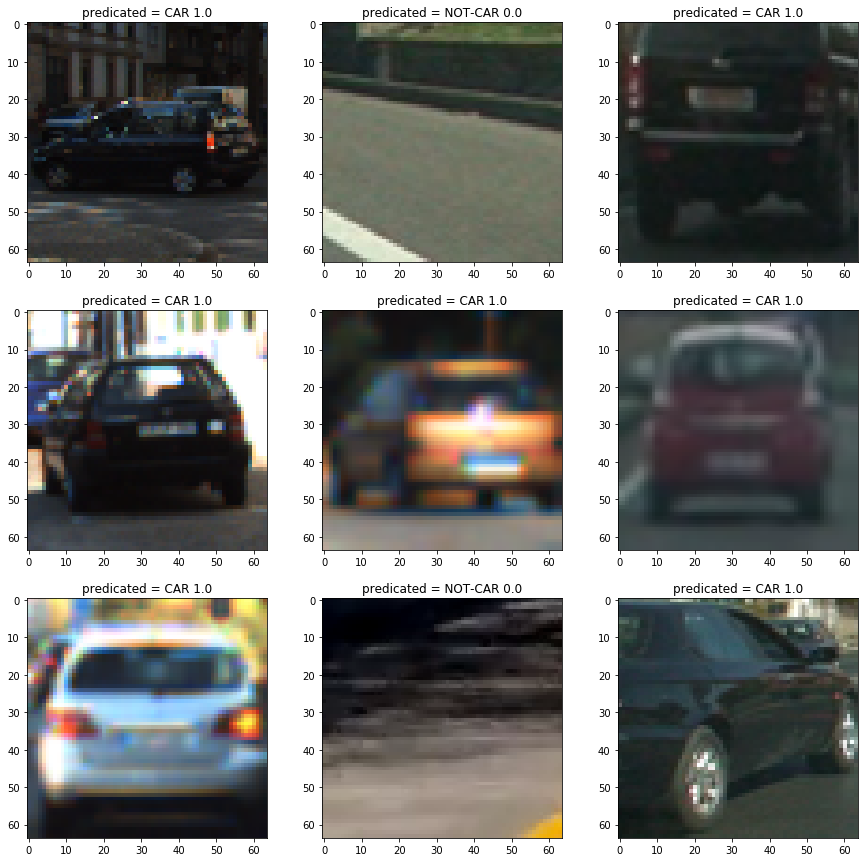

In [78]:
fig, axis = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        random_num = np.random.choice(2)
        if (random_num == 0):
            #car image
            k = np.random.choice(len(vehicle_imgs))
            axis[i, j].imshow(vehicle_imgs[k])
            score, predict_lable = predict_score(vehicle_imgs[k], final_classifier, final_classifier_params)
            axis[i, j].set_title("predicated = " + predict_lable + " " + str(score))
        else:
            k = np.random.choice(len(non_vehicle_imgs))
            axis[i, j].imshow(non_vehicle_imgs[k])
            score, predict_lable = predict_score(non_vehicle_imgs[k], final_classifier, final_classifier_params)
            axis[i, j].set_title("predicated = " + predict_lable + " " + str(score))

## 2. Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbx in bboxes:
        cv2.rectangle(draw_img, bbx[0], bbx[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    
    x_step = np.int(xy_window[0]* (1- xy_overlap[0]))
    y_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    for x_cur in range(x_start_stop[0], x_start_stop[1] - xy_window[0] + 1, x_step):
        for y_cur in range(y_start_stop[0], y_start_stop[1] - xy_window[1] + 1, y_step):
            window_list.append(((x_cur, y_cur),(x_cur + xy_window[0], y_cur + xy_window[1])))
    return window_list


In [ ]:
windows = slide_window(car_img_test, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(car_img_test, windows, color=(0, 0, 255), thick=6)

In [ ]:
fig, (without_windows, with_windows) = plt.subplots(1, 2, figsize=(10,10))
without_windows.imshow(car_img_test)
without_windows.set_title("Car")
with_windows.imshow(window_img)
with_windows.set_title("Car with windows")

In [ ]:
plt.imshow(window_img)

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#### Test an Image

In [ ]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [ ]:
features, hog_image = hog_obj.get_hog_features_hog_image(car_test[:,:,0])

In [ ]:
plt.imshow(hog_image, 'gray')

In [ ]:
features = hog_obj.get_hog_features(car_test[:,:,0])

In [ ]:
features